# feedback-prize-effectiveness

## import libraries

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

import pandas as pd

import torch
import transformers
import datasets

import importlib
#importlib.reload(load_data)


In [6]:
is_kaggle=os.getenv('KAGGLE_KERNEL_RUN_TYPE', '')

if not is_kaggle:

    sys.path.append('../')

    from src.utils import config
    #from src.utils import logger
    from src.data import load_data

    from src.models.huggingface_transformers import BERT

    from src.training.huggingface_transformers import trainer

In [ ]:
#logger=logger.Logger('test_log')

In [7]:
CFG=config.CFG(competition_name='feedback-prize-2021')
CFG.debug=False
CFG.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [8]:
CFG.data_path

'../data/'

## data

In [13]:
if not CFG.is_kaggle :
    load_data.download_data(CFG.data_path+CFG.competition_name+'/',CFG.competition_name)

100%|██████████| 32.4M/32.4M [00:01<00:00, 24.9MB/s]


None


In [15]:
train_csv,sample_submission_csv=load_data.load_data(CFG.data_path+CFG.competition_name+'/',debug=CFG.debug)
test_csv=sample_submission_csv.copy()

In [16]:
train_csv

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring
7881,2C27E003116B,1.622648e+12,408.0,529.0,Think of all the money people would save becau...,Claim,Claim 1,71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 8...
89707,7BEB99575D62,1.615844e+12,135.0,198.0,Popular vote is a more efficent way to vote fo...,Claim,Claim 1,21 22 23 24 25 26 27 28 29 30 31 32
64633,CE4EFA6441C4,1.614611e+12,935.0,1460.0,"or most problems, the town pays people or a bu...",Evidence,Evidence 2,168 169 170 171 172 173 174 175 176 177 178 17...
132774,0EE6F614F2F0,1.618171e+12,110.0,180.0,Seeking more than one opinion can provide som...,Position,Position 1,20 21 22 23 24 25 26 27 28 29 30
92682,6E72E9EADF75,1.614702e+12,0.0,326.0,""" What's wrong with the Electoral College?"" To...",Lead,Lead 1,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
...,...,...,...,...,...,...,...,...
13354,96DE1AD15FD2,1.622567e+12,2996.0,4037.0,WEEE-WOO-WEEH-WOO\n\n!!! This is the sound of ...,Evidence,Evidence 4,505 506 507 508 509 510 511 512 513 514 515 51...
32205,D9B3809280F9,1.615924e+12,180.0,238.0,Doing activities that aren't required have man...,Evidence,Evidence 1,27 28 29 30 31 32 33 34
19805,EF3D0D368ED7,1.618800e+12,663.0,703.0,it provides a challenge to the students.,Claim,Claim 4,112 113 114 115 116 117 118
117521,631F9CBDFD7A,1.621448e+12,129.0,170.0,"some students like work on the computers,",Claim,Claim 2,24 25 26 27 28 29 30


In [17]:
test_csv['discourse_text']=[open(CFG.data_path+'feedback-prize-2021/test/'+id+'.txt', 'r', encoding='UTF-8').read() for id in test_csv.id]
test_csv

,id,class,predictionstring,discourse_text
0,18409261F5C2,NaN,NaN,80% of Americans believe seeking multiple opin...
1,D46BCB48440A,NaN,NaN,"When people ask for advice,they sometimes talk..."
2,0FB0700DAF44,NaN,NaN,"During a group project, have you ever asked a ..."
3,D72CB1C11673,NaN,NaN,Making choices in life can be very difficult. ...
4,DF920E0A7337,NaN,NaN,Have you ever asked more than one person for h...


## feature

In [18]:
model_name='BERT'

training=True

if training:
    pretrained_model='bert-base-uncased'
    #pretrained_model=CFG.output_path+''
else :
    pretrained_model=CFG.weights_path+model_name+'/'
    

model=BERT.transformers_BERT(pretrained_path=pretrained_model,device=CFG.device)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [19]:
train_csv['input'] = train_csv.discourse_text
test_csv['input'] = test_csv.discourse_text

In [20]:
train_csv['label']=train_csv['discourse_type']
train_csv = train_csv.replace(
    {
        "label":
        {
            'Lead': 0,
            'Position': 1,
            'Evidence': 2,
            'Claim': 3,
            'Concluding Statement': 4,
            'Counterclaim': 5,
            'Rebuttal': 6
        }
    }
)

#train_csv = train_csv.rename(columns = {"discourse_effectiveness": "label"})

In [21]:
train_csv

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring,input,label
7881,2C27E003116B,1.622648e+12,408.0,529.0,Think of all the money people would save becau...,Claim,Claim 1,71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 8...,Think of all the money people would save becau...,3
89707,7BEB99575D62,1.615844e+12,135.0,198.0,Popular vote is a more efficent way to vote fo...,Claim,Claim 1,21 22 23 24 25 26 27 28 29 30 31 32,Popular vote is a more efficent way to vote fo...,3
64633,CE4EFA6441C4,1.614611e+12,935.0,1460.0,"or most problems, the town pays people or a bu...",Evidence,Evidence 2,168 169 170 171 172 173 174 175 176 177 178 17...,"or most problems, the town pays people or a bu...",2
132774,0EE6F614F2F0,1.618171e+12,110.0,180.0,Seeking more than one opinion can provide som...,Position,Position 1,20 21 22 23 24 25 26 27 28 29 30,Seeking more than one opinion can provide som...,1
92682,6E72E9EADF75,1.614702e+12,0.0,326.0,""" What's wrong with the Electoral College?"" To...",Lead,Lead 1,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,""" What's wrong with the Electoral College?"" To...",0
...,...,...,...,...,...,...,...,...,...,...
13354,96DE1AD15FD2,1.622567e+12,2996.0,4037.0,WEEE-WOO-WEEH-WOO\n\n!!! This is the sound of ...,Evidence,Evidence 4,505 506 507 508 509 510 511 512 513 514 515 51...,WEEE-WOO-WEEH-WOO\n\n!!! This is the sound of ...,2
32205,D9B3809280F9,1.615924e+12,180.0,238.0,Doing activities that aren't required have man...,Evidence,Evidence 1,27 28 29 30 31 32 33 34,Doing activities that aren't required have man...,2
19805,EF3D0D368ED7,1.618800e+12,663.0,703.0,it provides a challenge to the students.,Claim,Claim 4,112 113 114 115 116 117 118,it provides a challenge to the students.,3
117521,631F9CBDFD7A,1.621448e+12,129.0,170.0,"some students like work on the computers,",Claim,Claim 2,24 25 26 27 28 29 30,"some students like work on the computers,",3


### train val split

In [22]:
essay_ids={'train':None,'val':None}
essay_ids['train'],essay_ids['val']=load_data.split(train_csv.id.unique())

In [23]:
train_csv['train_val']=train_csv.id.isin(essay_ids['train']).replace({True: 'train',False: 'val'})

In [24]:
df={'train':None,'val':None,'test':None}
df['train']=train_csv[train_csv['train_val']=='train']
df['val']=train_csv[train_csv['train_val']=='val']
df['test']=test_csv

## training

In [25]:
dataset={'train':None,'val':None,'test':None}

dataset['train'] = datasets.Dataset.from_pandas(df['train'])
dataset['val'] = datasets.Dataset.from_pandas(df['val'])
dataset['test'] = datasets.Dataset.from_pandas(df['test'])

In [26]:
df['val'].keys()

Index(['id', 'discourse_id', 'discourse_start', 'discourse_end',
       'discourse_text', 'discourse_type', 'discourse_type_num',
       'predictionstring', 'input', 'label', 'train_val'],
      dtype='object')

In [27]:
dataset

{'train': Dataset({
     features: ['id', 'discourse_id', 'discourse_start', 'discourse_end', 'discourse_text', 'discourse_type', 'discourse_type_num', 'predictionstring', 'input', 'label', 'train_val', '__index_level_0__'],
     num_rows: 1149
 }),
 'val': Dataset({
     features: ['id', 'discourse_id', 'discourse_start', 'discourse_end', 'discourse_text', 'discourse_type', 'discourse_type_num', 'predictionstring', 'input', 'label', 'train_val', '__index_level_0__'],
     num_rows: 294
 }),
 'test': Dataset({
     features: ['id', 'class', 'predictionstring', 'discourse_text', 'input'],
     num_rows: 5
 })}

In [28]:
dataset['train'][0]

{'id': '2C27E003116B',
 'discourse_id': 1622648395409.0,
 'discourse_start': 408.0,
 'discourse_end': 529.0,
 'discourse_text': "Think of all the money people would save because they wouldn't have to spend so much on gas and maintence of their cars. ",
 'discourse_type': 'Claim',
 'discourse_type_num': 'Claim 1',
 'predictionstring': '71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93',
 'input': "Think of all the money people would save because they wouldn't have to spend so much on gas and maintence of their cars. ",
 'label': 3,
 'train_val': 'train',
 '__index_level_0__': 7881}

In [29]:
model.tokenizer(dataset['train'][0]["input"], max_length=512, truncation=True, padding="max_length")

{'input_ids': [101, 2228, 1997, 2035, 1996, 2769, 2111, 2052, 3828, 2138, 2027, 2876, 1005, 1056, 2031, 2000, 5247, 2061, 2172, 2006, 3806, 1998, 2364, 6528, 3401, 1997, 2037, 3765, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [30]:
dataset['train']

Dataset({
    features: ['id', 'discourse_id', 'discourse_start', 'discourse_end', 'discourse_text', 'discourse_type', 'discourse_type_num', 'predictionstring', 'input', 'label', 'train_val', '__index_level_0__'],
    num_rows: 1149
})

In [31]:
def f(x):return model.tokenizer(x['input'],truncation=True)

dataset['train']=dataset['train'].map(
    f,
    batched=True,
    remove_columns=(
        'id',
        'discourse_id',
        'discourse_start',
        'discourse_end',
        'discourse_text',
        'discourse_type',
        'discourse_type_num',
        'predictionstring',
        'input',
        #'label',
        'train_val',
        '__index_level_0__'
    )
)
dataset['val']=dataset['val'].map(
    f,
    batched=True,
    remove_columns=(
        'id',
        'discourse_id',
        'discourse_start',
        'discourse_end',
        'discourse_text',
        'discourse_type',
        'discourse_type_num',
        'predictionstring',
        'input',
        #'label',
        'train_val',
        '__index_level_0__'
    )
)
dataset['test']=dataset['test'].map(
    f,
    batched=True,
    remove_columns=(
        'id',

        'class',
        'predictionstring',


        # 'discourse_id',
        # 'essay_id',
        # 'discourse_text',
        # 'discourse_type',
        # #'discourse_effectiveness',
        # 'input',
        #'__index_level_0__',#
    )
)

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [32]:
dataset

{'train': Dataset({
     features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 1149
 }),
 'val': Dataset({
     features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 294
 }),
 'test': Dataset({
     features: ['discourse_text', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 5
 })}

In [33]:
datasetdict=datasets.DatasetDict({
    "train":dataset['train'],
    "val": dataset['val'],
})

In [34]:
trainer_ = trainer.transformers_get_trainer(CFG.output_path+model_name+'/',model.model,model.tokenizer,datasetdict)

In [35]:
if training:
    trainer_.train()
    #trainer.save_model(output_dir=CFG.output_path+model_name+'/')

/opt/conda/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1149
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 720
/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Log loss
1,1.736300,1.592460,1.592459
2,1.462800,1.374953,1.374953
3,1.280700,1.305242,1.305242
4,1.151800,1.226415,1.226415
5,1.032000,1.194439,1.194439
6,0.938700,1.163647,1.163647
7,0.863000,1.153612,1.153612
8,0.809000,1.145020,1.145021
9,0.787600,1.136656,1.136656
10,0.771700,1.136476,1.136476


***** Running Evaluation *****
  Num examples = 294
  Batch size = 32
/root/workspace/feedback-prize-2021/notebooks/../src/training/huggingface_transformers/trainer.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  torch.nn.functional.softmax(
Saving model checkpoint to ../output/BERT/checkpoint-72
Configuration saved in ../output/BERT/checkpoint-72/config.json
Model weights saved in ../output/BERT/checkpoint-72/pytorch_model.bin
tokenizer config file saved in ../output/BERT/checkpoint-72/tokenizer_config.json
Special tokens file saved in ../output/BERT/checkpoint-72/special_tokens_map.json
/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 2

In [36]:
trainer_.state.log_history

[{'loss': 1.7363, 'learning_rate': 8e-06, 'epoch': 1.0, 'step': 72},
 {'eval_loss': 1.5924595594406128,
  'eval_log loss': 1.5924594899018605,
  'eval_runtime': 1.8175,
  'eval_samples_per_second': 161.764,
  'eval_steps_per_second': 5.502,
  'epoch': 1.0,
  'step': 72},
 {'loss': 1.4628,
  'learning_rate': 7.758770483143633e-06,
  'epoch': 2.0,
  'step': 144},
 {'eval_loss': 1.374953031539917,
  'eval_log loss': 1.3749530398521295,
  'eval_runtime': 1.8154,
  'eval_samples_per_second': 161.95,
  'eval_steps_per_second': 5.509,
  'epoch': 2.0,
  'step': 144},
 {'loss': 1.2807,
  'learning_rate': 7.064177772475912e-06,
  'epoch': 3.0,
  'step': 216},
 {'eval_loss': 1.3052420616149902,
  'eval_log loss': 1.3052419665313901,
  'eval_runtime': 1.8506,
  'eval_samples_per_second': 158.869,
  'eval_steps_per_second': 5.404,
  'epoch': 3.0,
  'step': 216},
 {'loss': 1.1518, 'learning_rate': 6e-06, 'epoch': 4.0, 'step': 288},
 {'eval_loss': 1.2264149188995361,
  'eval_log loss': 1.226414846421

[]

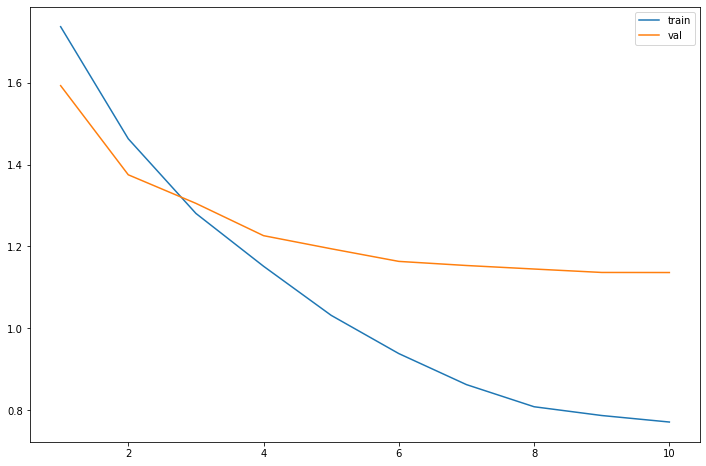

In [38]:
plt.figure(figsize=(12, 8))

plt.plot(
    [x['epoch'] for x in trainer_.state.log_history if 'loss' in x.keys()],
    [x['loss'] for x in trainer_.state.log_history if 'loss' in x.keys()],
    label='train',
)

plt.plot(
    [x['epoch'] for x in trainer_.state.log_history if 'eval_loss' in x.keys()],
    [x['eval_loss'] for x in trainer_.state.log_history if 'eval_loss' in x.keys()],
    label='val'
)

plt.legend()
plt.plot()

## prediction

In [ ]:
# preds=torch.Tensor(trainer_.predict(dataset['test']).predictions)
# preds = torch.nn.functional.softmax(preds,dim=1).numpy().astype(float)
# preds

***** Running Prediction *****
  Num examples: Unknown
  Batch size = 16


TypeError: object of type 'NoneType' has no len()

In [ ]:
# submission=sample_submission_csv.copy()
# submission['Ineffective'] = preds[:,0]
# submission['Adequate'] = preds[:,1]
# submission['Effective'] = preds[:,2]
# submission

,discourse_id,Ineffective,Adequate,Effective
0,a261b6e14276,0.033611,0.329639,0.636750
1,5a88900e7dc1,0.055210,0.625507,0.319282
2,9790d835736b,0.048238,0.689413,0.262349
3,75ce6d68b67b,0.057263,0.735350,0.207387
4,93578d946723,0.037477,0.598508,0.364015
5,2e214524dbe3,0.025827,0.255187,0.718986
6,84812fc2ab9f,0.043882,0.361060,0.595058
7,c668ff840720,0.068903,0.722844,0.208253
8,739a6d00f44a,0.104266,0.599784,0.295950
9,bcfae2c9a244,0.035709,0.382357,0.581935


In [ ]:
# submission.to_csv('submission.csv',index=False)

In [ ]:
#sample_submission_csv.to_csv('submission.csv',index=False)